In [13]:
def in_jupyter():
    try:
        from IPython import get_ipython
        shell = get_ipython().__class__.__name__
        print(f"Running in shell: {shell}")
        return shell == "ZMQInteractiveShell"
    except Exception:
        return False

if in_jupyter():
    from IPython import get_ipython
    ip = get_ipython()
    ip.run_line_magic("load_ext", "autoreload")
    ip.run_line_magic("autoreload", "3")


import matplotlib.pyplot as plt
import numpy as np

plt.style.use("dark_background")


Running in shell: ZMQInteractiveShell
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# LOAD BASE DATASET

from cwc.src.data import Dataset
from cwc.src.signal import NoisyData


dataset = Dataset()
dataset.load_from_mat("cwc/data/D1.mat")

print("Loaded Dataset:")
print("\tData shape:", dataset.data.shape)
print("\tIndices shape:", dataset.indices.shape)
print("\tClasses shape:", dataset.classes.shape)
print("\tUnique classes:", np.unique(dataset.classes))
print("\tClass instances:", np.bincount(dataset.classes))
print("\tMin distance between spikes:", np.min(np.diff(np.sort(dataset.indices))))

# SPLIT DATASET INTO TRAINING AND TEST SETS

train_data = dataset
test_data = train_data.split_into_test(test_ratio=0.2)

# print basic info about the training and test sets
print("\nTraining Set:")
print("\tData shape:", train_data.data.shape)
print("\tIndices shape:", train_data.indices.shape)
print("\tClasses shape:", train_data.classes.shape)
print("\tClass instances:", np.bincount(train_data.classes))
print("\nTest Set:")
print("\tData shape:", test_data.data.shape)
print("\tIndices shape:", test_data.indices.shape)
print("\tClasses shape:", test_data.classes.shape)
print("\tClass instances:", np.bincount(test_data.classes))


Loaded Dataset:
	Data shape: (1440000,)
	Indices shape: (2176,)
	Classes shape: (2176,)
	Unique classes: [1 2 3 4 5]
	Class instances: [  0 458 441 406 444 427]
	Min distance between spikes: 1

Training Set:
	Data shape: (1152000,)
	Indices shape: (1763,)
	Classes shape: (1763,)
	Class instances: [  0 354 367 323 371 348]

Test Set:
	Data shape: (288000,)
	Indices shape: (413,)
	Classes shape: (413,)
	Class instances: [  0 104  74  83  73  79]


Running in shell: ZMQInteractiveShell


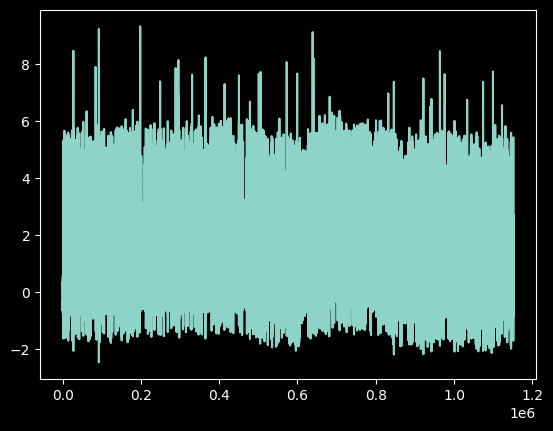

Running in shell: ZMQInteractiveShell


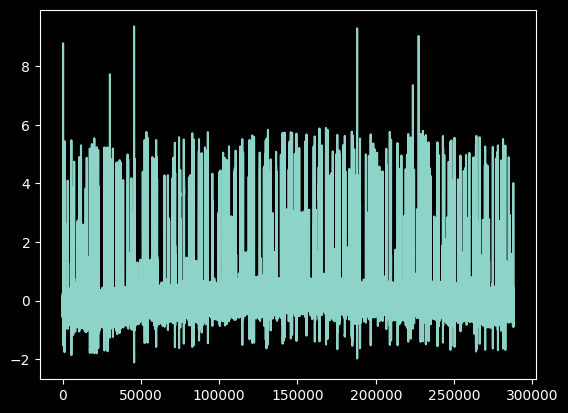

In [15]:

if in_jupyter():
    plt.plot(train_data.data)
    plt.show()

if in_jupyter():
    plt.plot(test_data.data)
    plt.show()


Noisy Dataset (noise level=0.1):
	Data shape: (1152000,)
	Indices shape: (1763,)
	Classes shape: (1763,)
	Class instances: [  0 354 367 323 371 348]


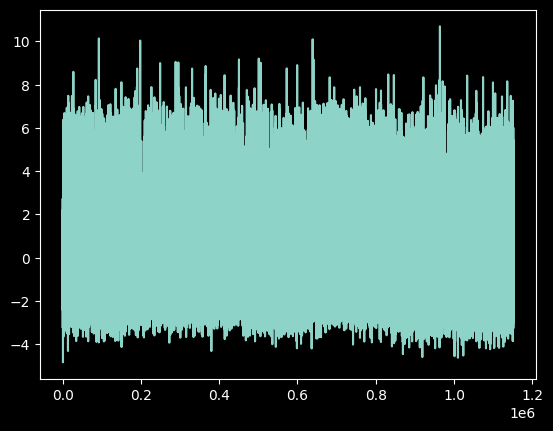


Noisy Dataset (noise level=0.3):
	Data shape: (1152000,)
	Indices shape: (1763,)
	Classes shape: (1763,)
	Class instances: [  0 354 367 323 371 348]


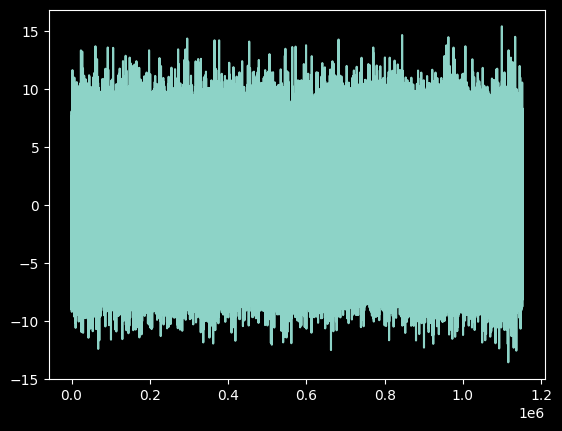


Noisy Dataset (noise level=0.5):
	Data shape: (1152000,)
	Indices shape: (1763,)
	Classes shape: (1763,)
	Class instances: [  0 354 367 323 371 348]


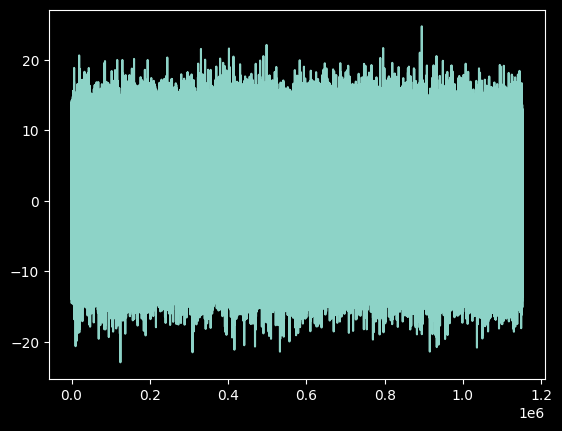

In [ ]:
# MAKE NOISIER DATASETS

noise_levels = [0.1, 0.3, 0.5]

noisy_datasets = []

for noise_level in noise_levels:
    noisy_data_maker = NoisyData(train_data)
    noisy_data_maker.noisify(noise_level)
    noisy_datasets.append(noisy_data_maker)
    print(f"\nNoisy Dataset (noise level={noise_level}):")
    print("\tData shape:", noisy_data_maker.data.shape)
    print("\tIndices shape:", noisy_data_maker.indices.shape)
    print("\tClasses shape:", noisy_data_maker.classes.shape)
    print("\tClass instances:", np.bincount(noisy_data_maker.classes))

    if in_jupyter():
        plt.plot(noisy_data_maker.data)
        plt.show()


Running in shell: ZMQInteractiveShell


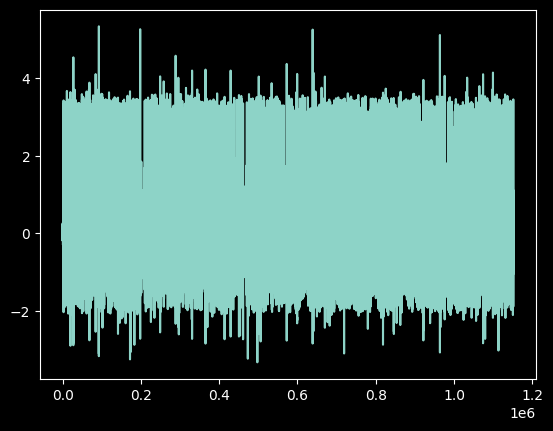

Running in shell: ZMQInteractiveShell


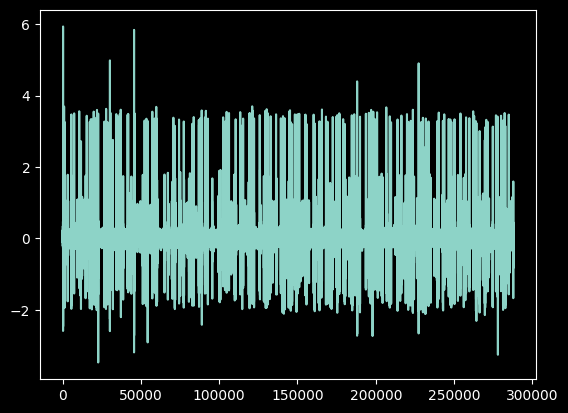

In [17]:
from cwc.src.signal import BandpassFilter
import matplotlib.pyplot as plt

train_filter = BandpassFilter(train_data)
train_filter.apply_band_pass_filter(filter_low=300, filter_high=3000, sample_rate=25000, order=4)

test_filter = BandpassFilter(test_data)
test_filter.apply_band_pass_filter(filter_low=300, filter_high=3000, sample_rate=25000, order=4)

if in_jupyter():
    plt.plot(train_filter.filtered_data)
    plt.show()

if in_jupyter():
    plt.plot(test_filter.filtered_data)
    plt.show()


Training Set Spike Detection:
	Correct Detections: 1682 out of  1763
	Total Detected Spikes: 1775
	False Positives: 93
	False Negatives: 81
	Incorrect Detections: 174
	Recall: 95.41%
	Precision: 94.76%
Running in shell: ZMQInteractiveShell


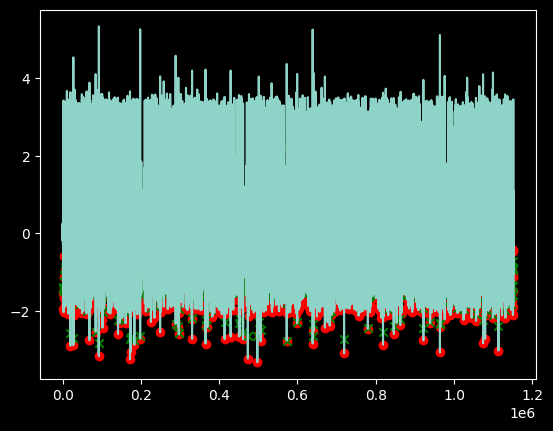

Running in shell: ZMQInteractiveShell


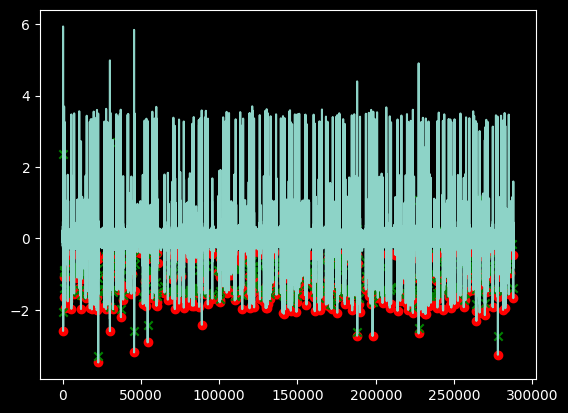

In [18]:
# TEST PURE MAD SPIKE DETECTION

from cwc.src.signal import SpikeDetector

mad_gain = 3.3
min_distance = 60

train_spikes = SpikeDetector(train_filter)
train_mad = train_spikes.calculate_mad()
train_spikes.detect_spikes(mad=train_mad, mad_gain=mad_gain, distance=min_distance)

test_spikes = SpikeDetector(test_filter)
test_mad = test_spikes.calculate_mad()
test_spikes.detect_spikes(mad=test_mad, mad_gain=mad_gain, distance=min_distance)

## evaluate spike detection performance on training set
correct_detections = 0
false_positives = 0
false_negatives = 0

for detected_spike in train_spikes.detected_spikes:
    if any(np.abs(train_spikes.indices - detected_spike) <= min_distance):
        correct_detections += 1
    else:
        false_positives += 1

incorrect_detections = false_positives + (len(train_spikes.indices) - correct_detections)

print("Training Set Spike Detection:")
print("\tCorrect Detections:", correct_detections, "out of ", len(train_spikes.indices))
print("\tTotal Detected Spikes:", len(train_spikes.detected_spikes))
print("\tFalse Positives:", false_positives)
print("\tFalse Negatives:", len(train_spikes.indices) - correct_detections)
print("\tIncorrect Detections:", incorrect_detections)
print("\tRecall: {:.2f}%".format(100 * correct_detections / len(train_spikes.indices)))
print("\tPrecision: {:.2f}%".format(100 * correct_detections / (correct_detections + false_positives)))

# plot detected spikes on training data, alonside the true spike indices

if in_jupyter():
    plt.plot(train_filter.filtered_data)
    plt.scatter(train_spikes.detected_spikes, train_filter.filtered_data[train_spikes.detected_spikes], color='red')
    plt.scatter(train_spikes.indices, train_filter.filtered_data[train_spikes.indices], color='green', marker='x')
    plt.show()

if in_jupyter():
    plt.plot(test_filter.filtered_data)
    plt.scatter(test_spikes.detected_spikes, test_filter.filtered_data[test_spikes.detected_spikes], color='red')
    plt.scatter(test_spikes.indices, test_filter.filtered_data[test_spikes.indices], color='green', marker='x')
    plt.show()


In [19]:
# After spike detection
from cwc.src.data import SignalProcessor

processor = SignalProcessor(train_data)
processor.filtered_data = train_filter.filtered_data

# Align and extract spikes
processor.detected_spikes = train_spikes.detected_spikes
processor.align_spikes(target_peak_pos=20, window_size=64)

# Extract PCA features
processor.extract_features()

# Match to ground truth for training
processor.correlate_classes(distance_threshold=50)

# Train classifier
classifier = processor.create_classifier()

print(f"Classifier trained with {len(processor.correlated_classes)} samples")
print(f"Training accuracy: {classifier.accuracy:.2%}")

Classifier trained with 1627 samples
Training accuracy: 100.00%


In [20]:
# Create new processor for test data
test_processor = SignalProcessor(test_data)
test_processor.filtered_data = test_filter.filtered_data
test_processor.detected_spikes = test_spikes.detected_spikes
test_processor.align_spikes(target_peak_pos=20, window_size=64)
test_processor.scaler = processor.scaler  # Use the same scaler as training
test_processor.pca = processor.pca  # Use the same PCA as training
test_processor.extract_features()

# Classify
predictions = classifier.classifier.predict(test_processor.features)

# Evaluate test set performance
correct_predictions = 0

for i, detected_index in enumerate(test_processor.aligned_indices):
    predicted_class = predictions[i]
    
    # Find closest ground truth spike
    distances = np.abs(test_data.indices - detected_index)
    closest_idx = np.argmin(distances)
    
    # Only count if detection is close enough to a real spike
    if distances[closest_idx] <= 50:
        true_class = test_data.classes[closest_idx]
        if predicted_class == true_class:
            correct_predictions += 1

total_predictions = len(predictions)
print("Test Set Classification:")
print("\tCorrect Predictions:", correct_predictions, "out of ", total_predictions)
print("\tAccuracy: {:.2f}%".format(100 * correct_predictions / total_predictions if total_predictions > 0 else 0))

Test Set Classification:
	Correct Predictions: 376 out of  419
	Accuracy: 89.74%


Running in shell: ZMQInteractiveShell


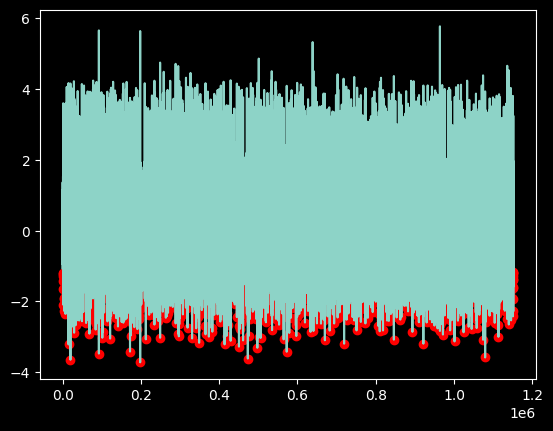

Training Set Spike Detection:
	Correct Detections: 1461 out of  1763
	Total Detected Spikes: 2818
	False Positives: 1357
	False Negatives: 302
	Incorrect Detections: 1659
	Precision: 51.85%
	Recall: 82.87%
Running in shell: ZMQInteractiveShell


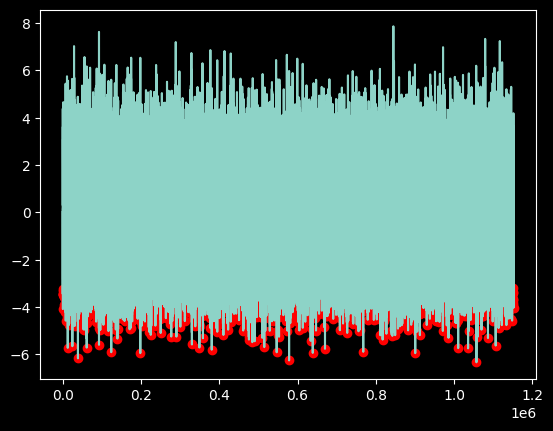

Training Set Spike Detection:
	Correct Detections: 869 out of  1763
	Total Detected Spikes: 2885
	False Positives: 2016
	False Negatives: 894
	Incorrect Detections: 2910
	Precision: 30.12%
	Recall: 49.29%
Running in shell: ZMQInteractiveShell


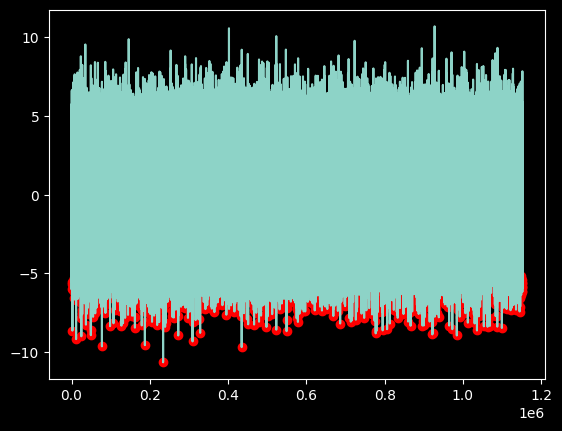

Training Set Spike Detection:
	Correct Detections: 689 out of  1763
	Total Detected Spikes: 2945
	False Positives: 2256
	False Negatives: 1074
	Incorrect Detections: 3330
	Precision: 23.40%
	Recall: 39.08%
Running in shell: ZMQInteractiveShell


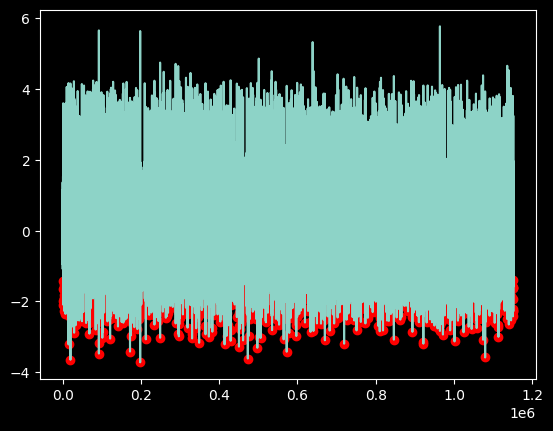

Training Set Spike Detection:
	Correct Detections: 1882 out of  1763
	Total Detected Spikes: 2156
	False Positives: 274
	False Negatives: -119
	Incorrect Detections: 155
	Precision: 87.29%
	Recall: 106.75%
Running in shell: ZMQInteractiveShell


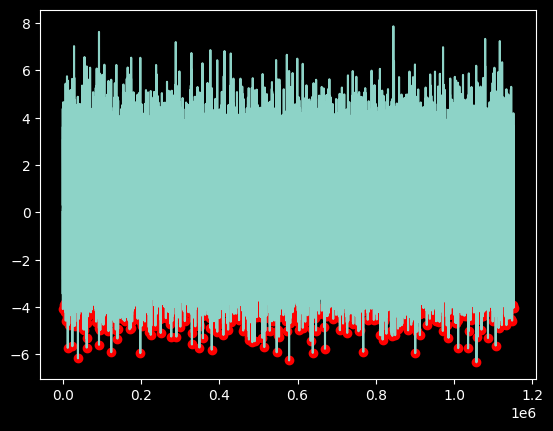

Training Set Spike Detection:
	Correct Detections: 378 out of  1763
	Total Detected Spikes: 885
	False Positives: 507
	False Negatives: 1385
	Incorrect Detections: 1892
	Precision: 42.71%
	Recall: 21.44%
Running in shell: ZMQInteractiveShell


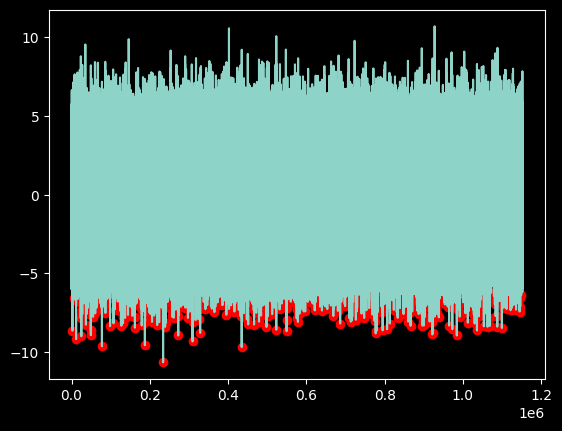

Training Set Spike Detection:
	Correct Detections: 227 out of  1763
	Total Detected Spikes: 841
	False Positives: 614
	False Negatives: 1536
	Incorrect Detections: 2150
	Precision: 26.99%
	Recall: 12.88%


In [ ]:
# test on noisy data

print("====STARTING NOISY DATA TESTS====")
for i, noisy_dataset in enumerate(noisy_datasets):
    
    unlabelled_filter = BandpassFilter(noisy_dataset)
    unlabelled_filter.apply_band_pass_filter(filter_low=300, filter_high=3000, sample_rate=25000, order=4)
    
    unlabelled_spikes = SpikeDetector(unlabelled_filter)
    unlabelled_mad = unlabelled_spikes.calculate_mad()
    unlabelled_spikes.detect_spikes(mad=unlabelled_mad, mad_gain=2.5, distance=min_distance)

    if in_jupyter():
        plt.plot(unlabelled_filter.filtered_data)
        plt.scatter(unlabelled_spikes.detected_spikes, unlabelled_filter.filtered_data[unlabelled_spikes.detected_spikes], color='red')
        plt.show()
    
    unlabelled_processor = SignalProcessor(noisy_dataset)
    unlabelled_processor.filtered_data = unlabelled_filter.filtered_data
    unlabelled_processor.detected_spikes = unlabelled_spikes.detected_spikes
    unlabelled_processor.align_spikes(target_peak_pos=20, window_size=64)
    unlabelled_processor.scaler = processor.scaler  # Use the same scaler as training
    unlabelled_processor.pca = processor.pca  # Use the same PCA as training
    unlabelled_processor.extract_features()
    
    unlabelled_predictions = classifier.classifier.predict(unlabelled_processor.features)

    # now evaluate against ground truth
    correct_detections = 0
    false_positives = 0
    false_negatives = 0

    for detected_spike in unlabelled_spikes.detected_spikes:
        if any(np.abs(unlabelled_spikes.indices - detected_spike) <= min_distance):
            correct_detections += 1
        else:
            false_positives += 1

    incorrect_detections = false_positives + (len(unlabelled_spikes.indices) - correct_detections)

    print(f"Single Pass Spike Detection ({noise_levels[i]}):")
    print("\tCorrect Detections:", correct_detections, "out of ", len(unlabelled_spikes.indices))
    print("\tTotal Detected Spikes:", len(unlabelled_spikes.detected_spikes))
    print("\tFalse Positives:", false_positives)
    print("\tFalse Negatives:", len(unlabelled_spikes.indices) - correct_detections)
    print("\tIncorrect Detections:", incorrect_detections)
    print("\tPrecision: {:.2f}%".format(100 * correct_detections / (correct_detections + false_positives)))
    print("\tRecall: {:.2f}%".format(100 * correct_detections / len(unlabelled_spikes.indices)))


for i, noisy_dataset in enumerate(noisy_datasets):
    
    unlabelled_filter = BandpassFilter(noisy_dataset)
    unlabelled_filter.apply_band_pass_filter(filter_low=300, filter_high=3000, sample_rate=25000, order=4)
    
    unlabelled_spikes = SpikeDetector(unlabelled_filter)
    unlabelled_mad = unlabelled_spikes.calculate_mad()
    unlabelled_spikes.two_pass_detection(mad=unlabelled_mad, initial_gain=3.0, secondary_gain=3.0, distance=min_distance)

    if in_jupyter():
        plt.plot(unlabelled_filter.filtered_data)
        plt.scatter(unlabelled_spikes.detected_spikes, unlabelled_filter.filtered_data[unlabelled_spikes.detected_spikes], color='red')
        plt.show()
    
    unlabelled_processor = SignalProcessor(noisy_dataset)
    unlabelled_processor.filtered_data = unlabelled_filter.filtered_data
    unlabelled_processor.detected_spikes = unlabelled_spikes.detected_spikes
    unlabelled_processor.align_spikes(target_peak_pos=20, window_size=64)
    unlabelled_processor.scaler = processor.scaler  # Use the same scaler as training
    unlabelled_processor.pca = processor.pca  # Use the same PCA as training
    unlabelled_processor.extract_features()
    
    unlabelled_predictions = classifier.classifier.predict(unlabelled_processor.features)

    # now evaluate against ground truth
    correct_detections = 0
    false_positives = 0
    false_negatives = 0

    for detected_spike in unlabelled_spikes.detected_spikes:
        if any(np.abs(unlabelled_spikes.indices - detected_spike) <= min_distance):
            correct_detections += 1
        else:
            false_positives += 1

    incorrect_detections = false_positives + (len(unlabelled_spikes.indices) - correct_detections)

    print(f"Two Pass Spike Detection ({noise_levels[i]}):")
    print("\tCorrect Detections:", correct_detections, "out of ", len(unlabelled_spikes.indices))
    print("\tTotal Detected Spikes:", len(unlabelled_spikes.detected_spikes))
    print("\tFalse Positives:", false_positives)
    print("\tFalse Negatives:", len(unlabelled_spikes.indices) - correct_detections)
    print("\tIncorrect Detections:", incorrect_detections)
    print("\tPrecision: {:.2f}%".format(100 * correct_detections / (correct_detections + false_positives)))
    print("\tRecall: {:.2f}%".format(100 * correct_detections / len(unlabelled_spikes.indices)))

print("====FINISHED NOISY DATA TESTS====")

Running in shell: ZMQInteractiveShell


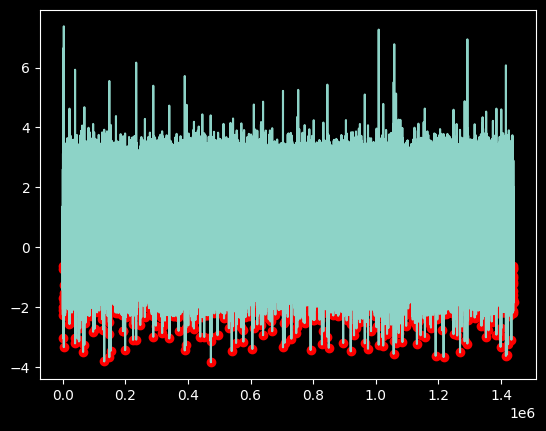

Predictions saved to cwc/data/D2.mat
Predictions for cwc/data/D2.mat: [  0 682 778 647 774 804]
Total spikes detected: 3685
Running in shell: ZMQInteractiveShell


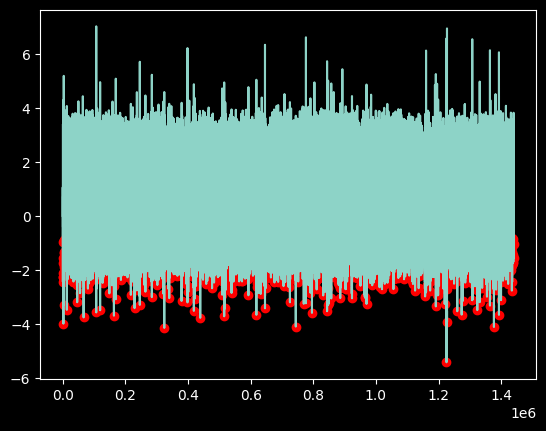

Predictions saved to cwc/data/D3.mat
Predictions for cwc/data/D3.mat: [  0 550 690 848 751 615]
Total spikes detected: 3454
Running in shell: ZMQInteractiveShell


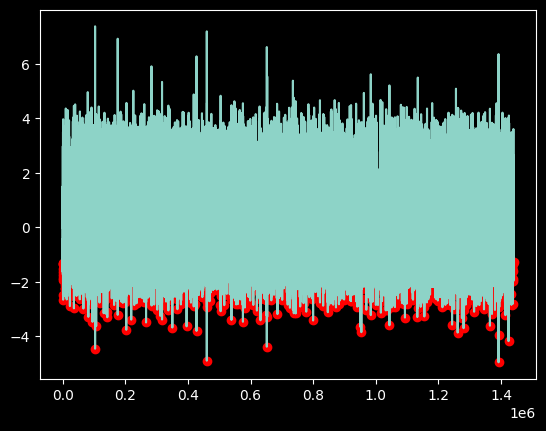

Predictions saved to cwc/data/D4.mat
Predictions for cwc/data/D4.mat: [   0  436  606  745 1063  702]
Total spikes detected: 3552
Running in shell: ZMQInteractiveShell


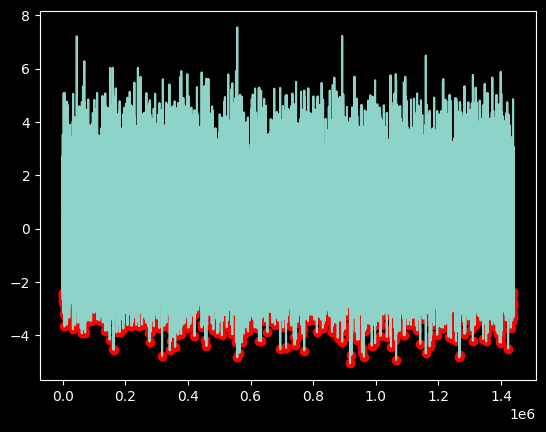

Predictions saved to cwc/data/D5.mat
Predictions for cwc/data/D5.mat: [   0  261  806  384 1035 1167]
Total spikes detected: 3653
Running in shell: ZMQInteractiveShell


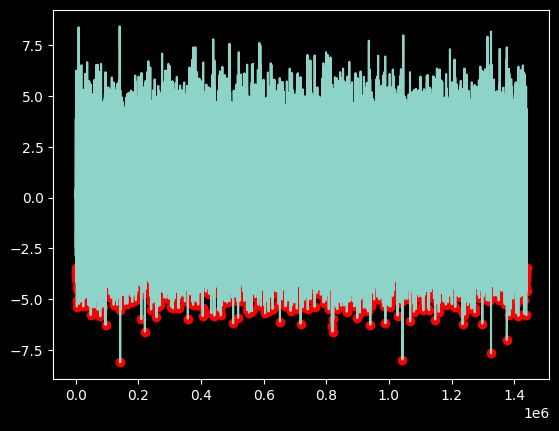

Predictions saved to cwc/data/D6.mat
Predictions for cwc/data/D6.mat: [   0  267 1085  207  560 1444]
Total spikes detected: 3563


In [22]:
# Now apply to the other datasets
unlabelled_datasets = ["cwc/data/D2.mat", "cwc/data/D3.mat", "cwc/data/D4.mat", "cwc/data/D5.mat", "cwc/data/D6.mat"]
mad_gains = [2.5, 2.5, 2.5, 2.5, 2.5]

i = 0
for dataset_path in unlabelled_datasets:

    mad_gain = mad_gains[i]
    i += 1

    unlabelled_data = Dataset()
    unlabelled_data.load_from_mat_unlabelled(dataset_path)
    
    unlabelled_filter = BandpassFilter(unlabelled_data)
    unlabelled_filter.apply_band_pass_filter(filter_low=300, filter_high=3000, sample_rate=25000, order=4)
    
    unlabelled_spikes = SpikeDetector(unlabelled_filter)
    unlabelled_mad = unlabelled_spikes.calculate_mad()
    unlabelled_spikes.detect_spikes(mad=unlabelled_mad, mad_gain=mad_gain, distance=min_distance)

    if in_jupyter():
        plt.plot(unlabelled_filter.filtered_data)
        plt.scatter(unlabelled_spikes.detected_spikes, unlabelled_filter.filtered_data[unlabelled_spikes.detected_spikes], color='red')
        plt.show()
    
    unlabelled_processor = SignalProcessor(unlabelled_data)
    unlabelled_processor.filtered_data = unlabelled_filter.filtered_data
    unlabelled_processor.detected_spikes = unlabelled_spikes.detected_spikes
    unlabelled_processor.align_spikes(target_peak_pos=20, window_size=64)
    unlabelled_processor.scaler = processor.scaler  # Use the same scaler as training
    unlabelled_processor.pca = processor.pca  # Use the same PCA as training
    unlabelled_processor.extract_features()
    
    unlabelled_predictions = classifier.classifier.predict(unlabelled_processor.features)


    unlabelled_data.write_to_mat(dataset_path.replace('cwc/data/', 'cwc/data/output/'), unlabelled_processor.aligned_indices, unlabelled_predictions)
    print(f"Predictions saved to {dataset_path.replace('cwc/data/;', 'cwc/data/output/')}")
    print(f"Predictions for {dataset_path}: {np.bincount(unlabelled_predictions)}")
    print(f"Total spikes detected: {len(unlabelled_processor.aligned_indices)}")

    
    


In [23]:
# Add this after your loop to verify
import scipy.io as spio
test_file = spio.loadmat('cwc/data/output/D6.mat')
print(f"D2 Index length: {len(test_file['Index'][0])}")
print(f"D2 Class length: {len(test_file['Class'][0])}")
print(f"Match: {len(test_file['Index']) == len(test_file['Class'])}")

D2 Index length: 3563
D2 Class length: 3563
Match: True
